## Setup

Import the relevant libraries, and setup pyhf the right way.

In [1]:
import pyhf
import numpy as np
import matplotlib.pyplot as plt
import pyhf.contrib.viz.brazil
from scipy import interpolate
from math import sqrt,ceil

# faster than minuit below
pyhf.set_backend("numpy")

# needed if we're going to do fits to extract uncertainties.
#pyhf.set_backend(pyhf.tensorlib, 'minuit')

# this will be useful for the limits.
def modellimit(CLs,poi):
    return np.interp(0.05,list(reversed(CLs)),list(reversed(poi)))

## How we'll run the limits

This will do all the heavy lifting of setting up the fit configuration and running the scan.  More documentation inline.

In [2]:
def singlebin(signal_data=10.0, backgr_data=1000.0, actual_data = 1000.0, 
              backgr_uncert=7, normsys=True, forceToys=False, forceAsymptotics=False, ntoys=1000):

    backgr_uncerts=None
    model=None
    
    max_mu=50
    
    if normsys:
        backgr_uncerts={"hi":1.+backgr_uncert/backgr_data, 
                        "lo":1.-backgr_uncert/backgr_data}
        model=pyhf.Model(
            {
                'parameters': [
                    {'name': 'mu', 'bounds': [[0, max_mu]]}
                ],
                'channels': [
                    {
                        'name': 'singlechannel',
                        'samples': [
                            {
                                'name': 'signal',
                                'data': [signal_data],
                                'modifiers': [
                                    {
                                        'name': 'mu', 
                                        'type': 'normfactor', 
                                        'data': None
                                    }
                                ],
                            },
                            {
                                'name': 'background',
                                'data': [backgr_data],
                                'modifiers': [
                                    {
                                        'name': 'bkguncrt',
                                        'type': 'normsys',
                                        'data': backgr_uncerts,
                                    }
                                ],
                            },
                        ],
                    }
                ]
            }
        )
    else:
        model = pyhf.simplemodels.hepdata_like(
            signal_data=[signal_data], 
            bkg_data=[backgr_data], 
            bkg_uncerts=[backgr_uncert]
        )

    data = [actual_data] + model.config.auxdata
    
    # scan finely near 0.0, less so at larger mu's.  This helps to make sure that the 
    # expected limit isn't subject to large interpolation effects when the observed limit
    # and signal yield are changing a lot.
    #
    # these numbers need some tuning based on the model.  If the limits get wonky when
    # the signal yield is large, then try increasing max_mu above.
    # there are certainly smarter ways to do this.
    poi_vals = np.append(np.append(np.linspace(0,2,21),np.linspace(2, 10, 21)),np.linspace(10,max_mu,11))

    
    # now figure out toys vs asymptotics   
    doAsymptotics=True
    if forceToys:
        doAsymptotics=False
    elif forceAsymptotics:
        doAsymptotics=True
    elif backgr_data<5:
        doAsymptotics=False
        
    args={}
    if doAsymptotics:
        calctype="asymptotics"
    else:
        calctype="toybased"
        args["ntoys"]=ntoys

    # actually do the fit.
    # to do: run an asymptotic fit first to find the right mu range, then
    # refine with better sampling in that range.
    results = [
        pyhf.infer.hypotest(test_poi, data, model, test_stat='qtilde', 
                            return_expected_set=True, 
                            calctype=calctype, **args
                           )
        for test_poi in poi_vals
    ]
    
    return poi_vals,results

## Data for the fits

Let's setup some dummy data to use for these tests.  We could also import something like this from hepdata.

In [3]:
# invariant mass, but this could be any variable that we use to parameterize the model
mass        =[   0,  100,  200,  300,  400,   500,   600,    700,    800,     900,    1000] # GeV

# background yields in 1 fb.  we'll call it a sigma, but it's more of a 
# "visible cross section", since we're not pretending to measure the 
# background acceptance or efficiency.
backgr_sigma=[7.35, 3.68, 1.47, 0.74, 0.38, 0.147, 0.074,  0.025, 0.0082,  0.0029,  0.0012] # fb

# signal cross sections
signal_sigma=[  20,  7.4,  2.2, 0.66, 0.18, 0.059, 0.022, 0.0075, 0.0025, 0.00081, 0.00028] # fb

# signal acceptance
signal_acc  =[0.30, 0.40, 0.45, 0.50, 0.55,  0.60,  0.65,   0.67,   0.70,    0.72,    0.75] # fraction

# signal efficiency
signal_eff  =[0.50, 0.52, 0.55, 0.57, 0.60,  0.65,  0.70,   0.72,   0.74,    0.76,    0.78] # fraction

Now we calculate the signal yield.  In an experiment we'd get this from MC simulation, for a reinterpretation we'd probably estimate it using sigma\*acc\*eff, where acc can be determined by running particle-level MC through selection that the search used to define the fiducial volume, and eff has to come from the experiment, e.g. from a model that the experiment did put constraints on, and that has 'similar' event kinematics (lepton momenta, jet momenta, MET, etc).

In [4]:
def signalYields(lumi):
    return [lumi*s*a*e for s,a,e in zip(signal_sigma,signal_acc,signal_eff)]

Also scale the background cross sections to get the background yields.  Doing it this way (instead of just specifying the yields) means we can scale the whole experiment up to a larger dataset just by changing the luminosity above.

In [5]:
def backgroundYields(lumi):
    return [lumi*b for b in backgr_sigma]

Let's check and see how much signal and background we expect given the cross sections above.

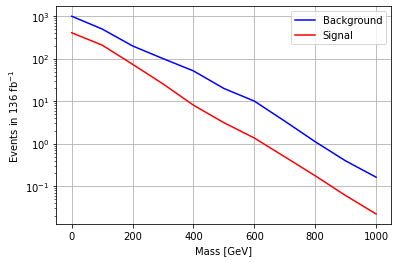

In [6]:
def plotSigBackground(lumi):
    plt.plot(mass,backgroundYields(lumi),"b",label="Background")
    plt.plot(mass,signalYields(lumi)    ,"r",label="Signal")
    plt.xlabel("Mass [GeV]")
    plt.ylabel(r"Events in %d fb$^{-1}$" % lumi)
    plt.grid()
    plt.yscale("log")
    plt.legend()
    plt.show()
    
plotSigBackground(136)

So we see that the signal and background will both go below 1 event at high masses.  Keep this in mind for when we're looking at limits at high masses.

## Scan over the signal strength and plot the results

This will produce traditional limit plots.  They're a bit simpler under the hood than what we normally do at the LHC (these are single-bin fits, not multi-bin fits, etc), but that's OK, they still illustrate the points we need to make here.

In [7]:
# we input the integrated luminosity of the data sample, in fb-1
def scanAndPlot(lumi,forceToys=False,forceAsymptotics=False,backgr_uncert=0):
    
    if forceToys and forceAsymptotics:
        print("Can't force both toys *and* asymptotics, choose one!")
        return

    signal_N=signalYields(lumi)
    backgr_N=backgroundYields(lumi)

    backgr_statunc=[]
    backgr_systunc=[]
    tot_uncerts=[]
    limit_exp=[]
    limit_obs=[]
    limit_exp_m2s=[]
    limit_exp_m1s=[]
    limit_exp_p1s=[]
    limit_exp_p2s=[]

    # we're fitting each bin separately, so don't think of this as a multi-bin fit.
    for m,backgr_data,signal_data,signal_xs,signal_a,signal_e in zip(mass,
                                                                     backgr_N,
                                                                     signal_N,
                                                                     signal_sigma,
                                                                     signal_acc,
                                                                     signal_eff):

        # this term is the systematic uncertainty on the background yield, in events
        backgr_systunc.append(backgr_data*backgr_uncert/100.)

        # this term is really better thought of the stat uncertainty on the data, 
        # assuming the signal is zero.
        backgr_statunc.append(sqrt(backgr_data))
        #
        # then the total uncertainty on the measurement is the sum in quadrature of the
        # systematic uncertainties on the background with the stat uncertainty on the data.
        # this is obviously simplified, but we'll see below that it does a remarkably good
        # job of tracking the limits in this kind of simplified fit.
        tot_uncert=sqrt(backgr_systunc[-1]**2 + backgr_statunc[-1]**2)

        # reframe this as the uncertainty on the background cross section, calculated as the
        # background yield/lumi, assuming the background has the same acc*eff as the signal.  
        # This is wrong, but that's OK -- we're just doing this so we can meaningfully compare 
        # the total BG uncertainty with the limits on the signal cross section.
        # if we had multiplied the limits below by "signal_data" instead of "signal_xs" then
        # we could just store "total_bg_unc" below, and we'd just be making the y-axis of
        # the plots in the next cell "Events" instead of "Cross Section"
        tot_uncerts.append(tot_uncert/(lumi*signal_a*signal_e))

        # using signal_data will work as long as the signal data is consistent with the
        # nominal bounds of the mu scan.  some tuning may be required if the signal
        # is either very large or very small compared to the background (uncertainty)
        #
        # to guard against this, if the signal is super small (which is where we see
        # most of the problems) use something comparable to the total background
        # uncertainty, and keep track of the scale factor for later.
        signal_data_for_fit=tot_uncert            

        # pass in the "real" signal data so we get the right observed limits.
        actual_data=backgr_data+signal_data

        poi_vals,results=singlebin(signal_data=signal_data_for_fit,
                                   backgr_data=backgr_data,
                                   backgr_uncert=backgr_systunc[-1],
                                   actual_data=actual_data,
                                   forceToys=forceToys,
                                   forceAsymptotics=forceAsymptotics)

        # all these numbers will be limits on mu, the multiplier of the signal yield.
        obs_CLs    =[el[0]    for el in results]   
        exp_CLs    =[el[1][2] for el in results]
        exp_CLs_m2s=[el[1][0] for el in results]
        exp_CLs_m1s=[el[1][1] for el in results]
        exp_CLs_p1s=[el[1][3] for el in results]
        exp_CLs_p2s=[el[1][4] for el in results]

        # undo the scaling we did above to the signal_data
        poi_vals*=signal_xs*signal_data_for_fit/signal_data

        # translate numbers above into limits on signal cross section by multiplying by signal XS
        limit_exp    .append(modellimit(exp_CLs    ,poi_vals))
        limit_exp_m2s.append(modellimit(exp_CLs_m2s,poi_vals))
        limit_exp_m1s.append(modellimit(exp_CLs_m1s,poi_vals))
        limit_exp_p1s.append(modellimit(exp_CLs_p1s,poi_vals))
        limit_exp_p2s.append(modellimit(exp_CLs_p2s,poi_vals))
        limit_obs    .append(modellimit(obs_CLs    ,poi_vals))

    plt.plot(mass,limit_obs,"k",label="Obs. limit (mu=1)")
    plt.fill_between(mass, limit_exp_m2s, limit_exp_p2s, facecolor='limegreen')
    plt.fill_between(mass, limit_exp_m1s, limit_exp_p1s, facecolor='yellow')
    plt.plot(mass,limit_exp,"k--",label="Exp. limit")
    plt.plot(mass,tot_uncerts,"c-.",label="Tot. Uncertainty")
    plt.plot(mass,signal_sigma,"r",label="Signal")
    plt.grid()
    plt.xlabel("Mass [GeV]")
    plt.ylabel("Cross Section [fb]")
    plt.yscale("log")
    plt.title("Background Systematic Uncertainty = %d%%" % backgr_uncert)
    plt.legend()
    plt.show()

## Let's run some limits

First let's check our search assuming 136 fb-1 of integrated lumi, using Asymptotics for the fit.  Asymptotics run fast, and they're pretty good as long as the stats are good.  We'll assume zero background uncertainty for now.

/home/jupyter-mhance/.conda/envs/fitting_20210217/lib/python3.9/site-packages/pyhf/infer/calculators.py:352: RuntimeWarning: invalid value encountered in double_scalars
  teststat = (qmu - qmu_A) / (2 * self.sqrtqmuA_v)


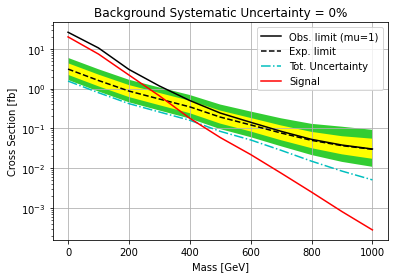

In [8]:
scanAndPlot(136,forceAsymptotics=True,backgr_uncert=0);

So we see the expected limit as the dashed line, with 1-sigma (yellow) and 2-sigma (green) bands around that.

The observed limit is the black line.  The observed limit is telling us what the data can say about this model.  In this case, since the data include signal at the expected rate, the observed limit is always above the signal injection, with some overall offset.  This makes sense -- we've observed BG+SIG, so the best we can say is that there isn't any more signal in the data than the signal we've injected into the data (plus a little bit to account for stat uncertainties, which get smaller as the background gets larger).  The observed limit is always higher than the signal yield, since we're including the signal in our observed data.  It's also always higher than the expected limit, since we've observed more events than we'd expect from just background.  The fact that the black solid line is always above the red line means that we can't exclude *any* of the models represented above (each mass point corresponds to a specific model).


Note that in all the plots above, we're assuming the data have both background *and* signal (at the rate predicted by the model shown in red).  If there were no signal, then only the observed limits (dark solid lines) would change, so that they would be on top of the expected limits (dashed black lines).

The expected limits are more interesting.  They're asking the question: if we observe exactly the background prediction in the data, then what's the most amount of signal that could be in the data (at 95% confidence level)?  Note that the expected limits (to first order) do NOT depend on the amount of signal passed in to actualdata -- they only care about the predicted background (and its uncertainty).  Observing the predicted background if there were to be signal in the data would necessarily imply a downward fluctuation in the background in order to accommodate the signal (while keeping the observed yields at the predicted background yield) so this will be determined by the overall uncertainty on the measurement.  The place where the red line crosses the expected limit line is the mass value that we expect to be able to exclude with this dataset...  we expect to exclude models where the red line is above the dashed line, and we expect to have no ability to constrain models where the red line is below the dashed line.

The expected limits more-or-less track the total uncertainty (green dashed line), offset by a factor of between 2 and 3.  (The "total uncertainty" here is the combination of the single uncertainty term on the background and the implied uncertainty on the observed data, which is approximately sqrt(N) for sufficiently large N.)  This also almost corresponds to the "-2 sigma" band of the expected limit, which also makes sense, since the 95% CL expected limit more or less corresponds to a hypothetical two-sigma fluctuation of the background in the observed data.  (1-sigma is around 68% CL, 2 sigma is around 95% CL, etc.)  This breaks down a bit at high masses, where the data yields get small -- we'll treat this region separately below, when we discuss toy Monte Carlo methods.

I've plotted this in terms of cross sections, since this is normally how we present results.  But note that we can translate everything above into "Events" by scaling by the lumi\*(signal acceptance)\*(signal efficiency) for each mass value, i.e. the inverse of what we did when storing the values of the total background uncertainty.

Now let's see what happens if we increase the background uncertainty to 10%.


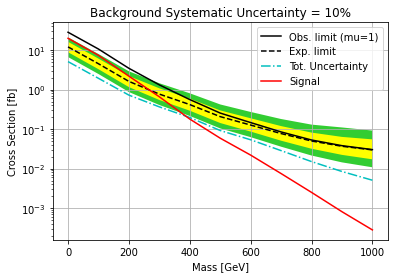

In [9]:
scanAndPlot(136,forceAsymptotics=True,backgr_uncert=10)

The expected limit moved up, following the total uncertainty trend, so that the intersection with the red line is now at a lower mass, and our search isn't as sensitive as it was before.  Let's make it more extreme and do 50% uncertainty:

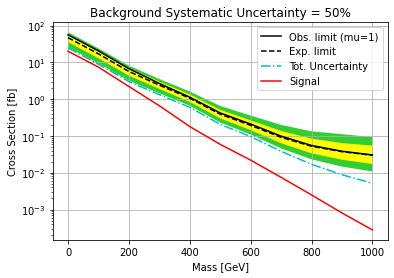

In [10]:
scanAndPlot(136,forceAsymptotics=True,backgr_uncert=50)

With a 50% uncertainty, we don't expect to exclude any of these models.  As the background uncertainty changes, the expected limits creep higher and higher, which also pushes the observed limits higher and higher -- if there's signal in the data, then the observed limit will need to be higher than the expected limit, even if the expected limit is above the signal trend.  If the signal is super-small, then the observed limit may seem like it's resting on top of the expected limit, but it won't go lower than the expected limit.

Let's increase the luminosity and see what happens (e.g. after the HL-LHC):

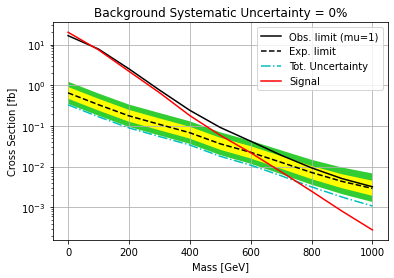

In [11]:
scanAndPlot(3000,forceAsymptotics=True,backgr_uncert=0.)

Now that we've increased the data sample, the expected limit on the model (where the red line crosses the black-dashed line) moves to larger masses.  Note that this assumes that we've made no analysis improvements between now and 2040, which is unlikely, but we've also assumed that the increased pileup at the HL-LHC has no impact on our search, which is also unlikely.  So take this projection with a grain of salt!

Let's go back and look at our nominal case of 136/fb and 0% background uncertainty:

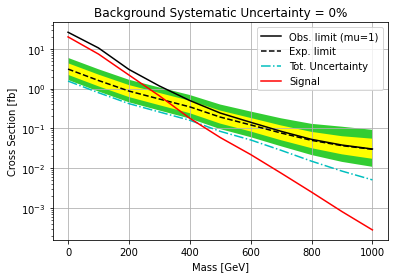

In [12]:
scanAndPlot(136,forceAsymptotics=True,backgr_uncert=0);

Note what's happening at 1 TeV.  The -2 sigma band goes to 0.01 fb, which means we're setting a limit on the signal *yield* (sigma\*lumi\*acceptance\*efficiency) of 0.01\*136\*0.75\*0.78=0.80 events.  But even if we have zero expected background events, just the Poisson uncertainty on the "true" value when observing 0 events is around 3.1 events.  Since "expect zero, observe zero" corresponds to the "best case" scenario for constraining signal, we should *never* get an exclusion on signal less than ~3.1 events.  That point lying within the 2-sigma coverage suggests that in 5% of experiments we should expect to see a limit that good, which is impossible!

This is a classic failure of the asymptotic approximation (sometimes called the "better than zero" problem), which basically relies on the assumption that the uncertainty on the data can be approximated with Gaussian statistics, and can't handle cases where the number of events in data are small (below 5 or so), where we need to use Poisson statistics.  (This is also the reason why we should use stat uncertainty bars calculated as Poisson uncertainties, so that bins with small numbers of events show the correct stat uncertainties.)  In cases where the number of events is small, we need to run toy MC.

Toy MC is expensive, and takes a while.  So the functions above are setup to only run toys when the stats are small (unless we force running toys for all points).  Even when running toys only for points that have poor stats, it will take a while (>10 minutes) to produce one plot, but we should see the -1 and -2 sigma uncertainty bands collapse to be on top of the median expected limit at the highest masses, while the +1 and +2 sigma uncertainties can still be seen going above the expected limit.

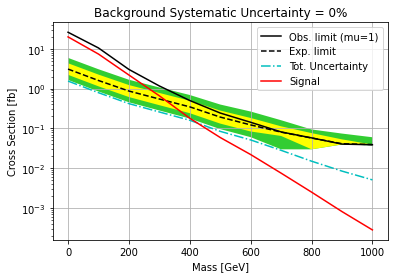

In [13]:
scanAndPlot(136,forceAsymptotics=False)

The bands are a bit jumpy because we're only sampling points every 100 GeV, and we're only running 1000 toys -- a finer signal binning and more toys will probably smooth the kinks out.  But we still see that by 1 TeV the expected limit bands that cover below the expected limit converge to the median, as expected.